# Installation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import optuna
import torch
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm, trange
import datasets
import pandas as pd
from map_boxes import mean_average_precision_for_boxes
from datasets import Dataset, DatasetDict
from blur.backend.config import CUSTOM_FACE_PATH, DATA_PATH, CASCADE_XML
from blur.backend.utils import seed_everything, prepare_dfs
from blur.backend.drawing import draw_predicted_bboxes
from blur.backend.models import Cascade

Couldn't import fast version of function compute_overlap, will use slow one. Check cython intallation


In [3]:
dataset = datasets.load_from_disk(str(CUSTOM_FACE_PATH))

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'faces'],
        num_rows: 6402
    })
    validation: Dataset({
        features: ['image', 'faces'],
        num_rows: 1527
    })
})

# OpenCV-Baseline

В качестве основы можно рассмотреть нестандартное техническое решение от OpenCV, которое работает на основе каскада слабых классификаторов (функций Хаара).\
Пример того, как они выглядят, ниже:

<div style="text-align: center;">
  <img src="https://docs.opencv.org/3.4/haar.png" alt="image.png">
</div>

Они представляют собой черно-белые паттерны, которые были получены на большом количестве данных для решения этой задачи.\
Важно понимать, что не каждый такой паттерн имеет смысл для интерпретации. Далее цитата из оригинальной статьи:
```
В верхнем ряду показаны две хорошие особенности. Кажется, что первый выбранный признак фокусируется на том свойстве, что область глаз часто темнее, чем область носа и щек. Второй выбранный признак основан на том свойстве, что глаза темнее переносицы. Но те же окошки, нанесенные на щеки или любое другое место, не имеют значения. Так как же нам выбрать лучшие функции из более чем 160 000 функций? Это достигается с помощью Adaboost.
```
Прочитать подробнее про Adaboost можно [здесь](https://habr.com/ru/companies/otus/articles/503888/) \
Прочитать подробнее про метод можно [здесь](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html).

In [22]:
cascade = Cascade()

predictions = []
split = "validation"
for idx in trange(len(dataset[split])):
    img = np.array(dataset[split][idx]['image'])
    
    faces = cascade.predict(
        images=np.expand_dims(img, 0), 
        idx=np.array([idx]),
    )
    predictions.extend(faces)

predictions = pd.DataFrame(predictions)

100%|███████████████████████████████████████| 1537/1537 [03:30<00:00,  7.31it/s]


In [7]:
dfs = prepare_dfs(dataset)

In [7]:
original_cols = ['img_id', 'label', 'xmin', 'xmax', 'ymin', 'ymax']
preds_cols = ['img_id', 'label', "confidence", 'xmin', 'xmax', 'ymin', 'ymax']
mean_ap, average_precisions = mean_average_precision_for_boxes(
    dfs["validation"][original_cols].values,
    predictions[preds_cols].values,
)

Number of files in annotations: 1537
Number of files in predictions: 1083
Unique classes: 1
Detections length: 1083
Annotations length: 1537
face                           | 0.218817 |    1952
mAP: 0.218817


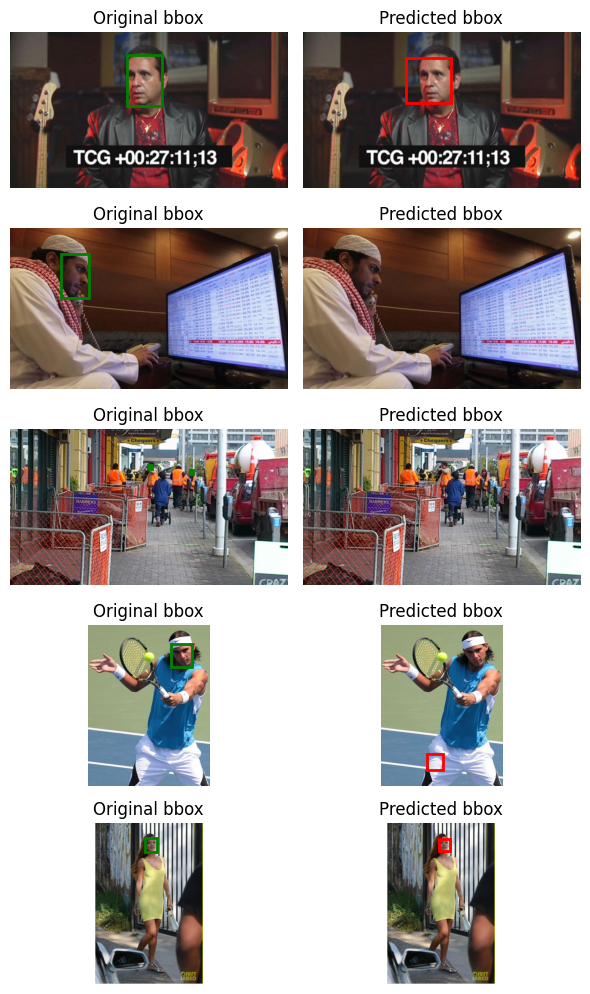

In [8]:
seed_everything(2)
draw_predicted_bboxes(dataset, dfs['validation'], predictions, n_images=5)

# Подбор гиперпараметров

In [11]:
def predict_batch(model, batch_size):
    original_cols = ['img_id', 'label', 'xmin', 'xmax', 'ymin', 'ymax']
    preds_cols = ['img_id', 'label', "confidence", 'xmin', 'xmax', 'ymin', 'ymax']

    idx = random.sample(dfs["train"]['img_id'].unique().tolist(), k=batch_size)
    batch = dataset["train"][idx]
    
    images = list(map(np.array, batch['image']))
    original = dfs['train'].query("img_id in @idx")
    preds = model.predict(images, idx=np.array(idx))
    preds = pd.DataFrame(preds)

    if preds.empty:
        return 0.0
    
    mean_ap, average_precisions = mean_average_precision_for_boxes(
        original[original_cols].values,
        preds[preds_cols].values,
    )
    return mean_ap

In [12]:
def objective(trial, batch_size):
    
    predict_params = {
        "scaleFactor": trial.suggest_float("scaleFactor", 1.01, 3.0),
        "minNeighbors": trial.suggest_int("minNeighbors", 1, 15),
        "minSize": (
            trial.suggest_int("minSize1", 10, 100), 
            trial.suggest_int("minSize2", 10, 100)
        ),
    }
    model = Cascade(predict_params=predict_params)
    mean_ap = predict_batch(model, batch_size)
    return mean_ap

In [32]:
batch_size, n_trials = 100, 100

study = optuna.create_study(direction='maximize')
study.optimize(
    partial(objective, batch_size=batch_size), 
    n_trials=n_trials,
)

[I 2024-06-02 14:45:29,345] A new study created in memory with name: no-name-b7c89303-411f-41bc-9b00-c4e70d468808


NameError: name 'objective' is not defined

In [36]:
len(dataset['train'])

6402

In [37]:
pd.DataFrame(dataset['train']["faces"])

,bbox,blur,expression,illumination,occlusion,pose,invalid
0,"[[449.0, 330.0, 122.0, 149.0]]",[0],[0],[0],[0],[0],[False]
1,"[[361.0, 98.0, 263.0, 339.0]]",[0],[0],[0],[0],[0],[False]
2,"[[122.0, 380.0, 10.0, 12.0], [246.0, 378.0, 12...","[2, 2]","[0, 0]","[0, 0]","[1, 0]","[0, 0]","[False, False]"
3,"[[294.0, 300.0, 455.0, 582.0]]",[0],[0],[0],[0],[0],[False]
4,"[[532.0, 168.0, 219.0, 287.0]]",[0],[0],[0],[0],[0],[False]
...,...,...,...,...,...,...,...
6397,"[[462.0, 140.0, 264.0, 362.0]]",[0],[0],[0],[0],[0],[False]
6398,"[[362.0, 108.0, 214.0, 277.0]]",[0],[0],[0],[0],[0],[False]
6399,"[[495.0, 222.0, 165.0, 222.0]]",[0],[0],[0],[0],[0],[False]
6400,"[[244.0, 46.0, 510.0, 614.0]]",[0],[0],[0],[0],[0],[False]


In [40]:
dfs = prepare_dfs(dataset)

100%|██████████████████████████████████████| 1527/1527 [00:06<00:00, 242.02it/s]


In [47]:
cascade = Cascade(predict_params={
    "scaleFactor": 1.21,
    "minNeighbors": 9,
    "minSize": (34, 54),
})

predictions = []
split = "validation"
for idx in trange(len(dataset[split])):
    sizes = dataset[split][idx]['image'].size    
    img = np.array(dataset[split][idx]['image'])
    
    faces = cascade.predict(
        images=np.expand_dims(img, 0), 
        idx=np.array([idx]),
    )

    for face in faces:
        face["size_w"] = sizes[0]
        face["size_h"] = sizes[1]
    predictions.extend(faces)

predictions = pd.DataFrame(predictions)

100%|███████████████████████████████████████| 1527/1527 [01:25<00:00, 17.81it/s]


In [50]:
original_cols = ['img_id', 'label', 'xmin', 'xmax', 'ymin', 'ymax']
preds_cols = ['img_id', 'label', "confidence", 'xmin', 'xmax', 'ymin', 'ymax']

original = dfs["validation"].copy()
preds = predictions.copy()

for df in [original, preds]:
    df['xmin'] = df['xmin'] / df['size_w']
    df['xmax'] = df['xmax'] / df['size_w']
    df['ymin'] = df['ymin'] / df['size_h']
    df['ymax'] = df['ymax'] / df['size_h']

mean_ap, average_precisions = mean_average_precision_for_boxes(
    original[original_cols].values,
    preds[preds_cols].values,
)

Number of files in annotations: 1527
Number of files in predictions: 607
Unique classes: 1
Detections length: 607
Annotations length: 1527
face                           | 0.317519 |    1940
mAP: 0.317519


In [53]:
predictions.to_csv(DATA_PATH / "preds-validation.csv", index=False)

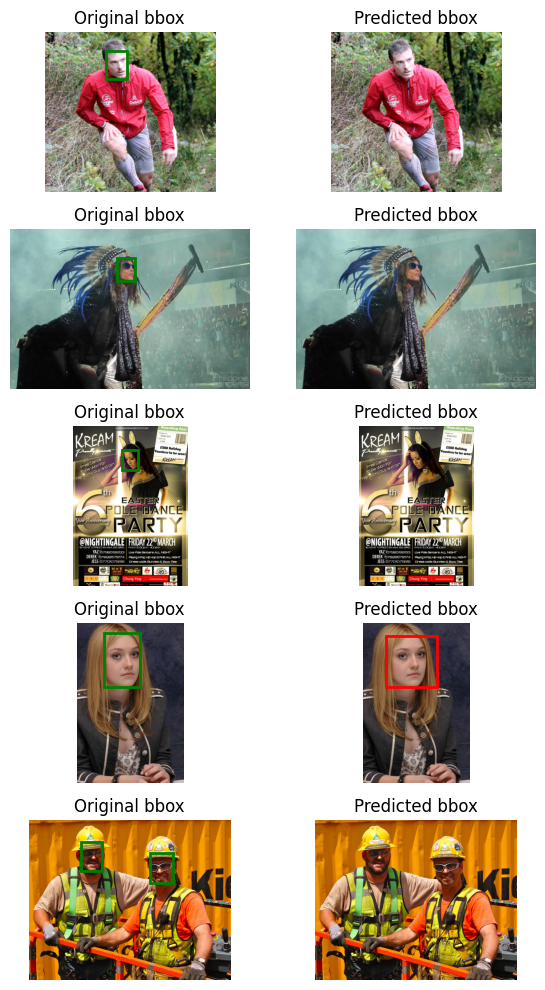

In [54]:
seed_everything()
draw_predicted_bboxes(dataset, dfs['validation'], predictions, n_images=5)